**1. Setting-up neccessary imports**

In [0]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

**2. Setting-up random seed for reproducibility and device.**

In [2]:
SEED = 456
np.random.seed(SEED)

if torch.cuda.is_available():
  torch.backends.cudnn.benchmark = True
  device = torch.device("cuda")
  torch.cuda.manual_seed(SEED)
else:
  device = torch.device("cpu")
  torch.manual_seed(SEED)
  
print("Device:", device)

Device: cuda


**3. Defining a transform variable to convert RGB images into tensors**

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

**4. Using above transform as an argument to load the training set and test set**

In [18]:
trainset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


**5. Print some statistics from defined dataset**

In [19]:
print(f"Shape of data (channels, height, width): {trainset.__getitem__(0)[0].shape}")
print(f"Length of train dataset: {len(trainset)}")
print(f"Classes of images of trainset: {trainset.classes}")
print(f"Length of test dataset: {len(testset)}")
print(f"Classes of images of testset: {testset.classes}")

Shape of data (channels, height, width): torch.Size([3, 32, 32])
Length of train dataset: 50000
Classes of images of trainset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Length of test dataset: 10000
Classes of images of testset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**6. Defining size of the batch and testloaders for training and validation data**

In [0]:
batch_size = 64

val_data, train_data = torch.utils.data.random_split(trainset, [10000, 40000])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

**7. Printing train images**

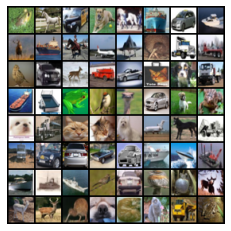

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
  npimg = img.cpu().numpy()
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

#get random train images
data_iter = iter(train_loader)
images, labels = data_iter.next()

#show images
imshow(torchvision.utils.make_grid(images))

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

**8.  Defining first Autoencoder model for with a compression ratio of 0.5 (the bottleneck have half the spatial resolution of the original input).**

In [0]:
class HalfSizedBottleneckAE(nn.Module):
    def __init__(self):
      super(HalfSizedBottleneckAE, self).__init__()

      #ENCODER
      # Input size: [batch, 3, 32, 32] => Output size: [batch, 12, 32, 32]
      self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size=3, stride=1, padding=1)
      # Input size: [batch, 12, 32, 32] => Output size: [batch, 36, 16, 16]
      self.conv_2 = nn.Conv2d(in_channels = 12, out_channels = 36, kernel_size=4, stride=2, padding=1)

      self.Leaky_ReLU = nn.LeakyReLU()

      #DECODER
      # Input size: [batch, 36, 16, 16] => Output size: [batch, 12, 16, 16]
      self.deconv_1 = nn.ConvTranspose2d(in_channels = 36, out_channels = 12, kernel_size = 4, stride=2, padding=1)
      # Input size: [batch, 12, 16, 16] => Output size: [batch, 3, 32, 32]
      self.deconv_2 = nn.ConvTranspose2d(in_channels = 12, out_channels = 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
      ### ENCODER
      x = self.conv_1(x)
      x = self.Leaky_ReLU(x)
      x = self.conv_2(x)
      x = self.Leaky_ReLU(x)
            
      ### DECODER
      x = self.deconv_1(x)
      x = self.Leaky_ReLU(x)
      x = self.deconv_2(x)
      x = self.Leaky_ReLU(x)
      logits = x
      probas = torch.sigmoid(logits)
        
      return logits, probas

**9.  Defining second Autoencoder model for with a compression ratio of 0.25 (the bottleneck have quarter the spatial resolution of the original input).**

In [0]:
class QuarterSizedBottleneckAE(nn.Module):
    def __init__(self):
      super(QuarterSizedBottleneckAE, self).__init__()

      #ENCODER
      # Input size: [batch, 3, 32, 32] => Output size: [batch, 12, 32, 32]
      self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size=3, stride=1, padding=1)
      # Input size: [batch, 12, 32, 32] => Output size: [batch, 36, 16, 16]
      self.conv_2 = nn.Conv2d(in_channels = 12, out_channels = 36, kernel_size=4, stride=2, padding=1)
      # Input size: [batch, 12, 16, 16] => Output size: [batch, 108, 8, 8]
      self.conv_3 = nn.Conv2d(in_channels = 36, out_channels = 108, kernel_size=4, stride=2, padding=1)
      self.Leaky_ReLU = nn.LeakyReLU()

      #DECODER
      # Input size: [batch, 108, 8, 8] => Output size: [batch, 36, 16, 16]
      self.deconv_1 = nn.ConvTranspose2d(in_channels = 108, out_channels = 36, kernel_size=4, stride=2, padding=1)
      # Input size: [batch, 36, 16, 16] => Output size: [batch, 12, 32, 32]
      self.deconv_2 = nn.ConvTranspose2d(in_channels = 36, out_channels = 12, kernel_size = 4, stride=2, padding=1)
      # Input size: [batch, 12, 32 32] => Output size: [batch, 3, 32, 32]
      self.deconv_3 = nn.ConvTranspose2d(in_channels = 12, out_channels = 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
      ### ENCODER
      x = self.conv_1(x)
      x = self.Leaky_ReLU(x)
      x = self.conv_2(x)
      x = self.Leaky_ReLU(x)
      x = self.conv_3(x)
      x = self.Leaky_ReLU(x)
            
      ### DECODER
      x = self.deconv_1(x)
      x = self.Leaky_ReLU(x)
      x = self.deconv_2(x)
      x = self.Leaky_ReLU(x)
      x = self.deconv_3(x)
      x = self.Leaky_ReLU(x)
      logits = x
      probas = torch.sigmoid(logits)
        
      return logits, probas

**10. Defining function for training model for one epoch**


In [0]:
def train_per_epoch(model, train_loader, criterion, optimizer):
  model.train()

  epoch_loss = 0.0

  for batch_idx, (features, targets) in enumerate(train_loader):

    features = features.to(device)

    logits, decoded = model(features)
    loss = criterion(logits, features)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  avg_train_loss = epoch_loss/(batch_idx+1)
  return avg_train_loss

**11. Defining function for validating model for one epoch**

In [0]:
def val_per_epoch(model, val_loader, criterion):

  epoch_loss = 0.0
  model.eval()

  with torch.no_grad():
    for batch_idx, (features, targets) in enumerate(train_loader):
      features = features.to(device)

      logits, decoded = model(features)
      loss = criterion(logits, features)

      epoch_loss += loss.item()

    avg_val_loss = epoch_loss/(batch_idx+1)
  
  return avg_val_loss

**12. Defining function for saving history of model training and validation**


In [0]:
def model_history(num_epochs, model, train_loader, criterion, optimizer):
  history = {}
  history['train_loss'] = []
  history['val_loss'] = []

  for epoch in range(num_epochs):
    train_loss = train_per_epoch(model, train_loader, criterion, optimizer)
    val_loss = val_per_epoch(model, val_loader, criterion)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print('\nEpoch: {}/{} | Training Loss: {:.4f} | Validation Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss,val_loss))

  return history

**13. Defining function for initializing our model and training it**


In [0]:
def init_model(num_epochs, learning_rate, model):
  if torch.cuda.is_available():
    model = model.to(device)

  print('\nModel Summary')
  print('=================================================================')
  print(summary(model, (3, 32, 32)))
  print('=================================================================')

  train_batch_num = len(train_loader)
  val_batch_num = len(val_loader)

  print('Total Sample: Train on {} samples, validate on {} samples.'.format(len(train_data), len(val_data)))
  print('Total Batch: Train on {} batches, validate on {} batches. {} samples/minibatch \n'.format(train_batch_num, val_batch_num, batch_size))
  print('\nStarting model training...')
  print('=================================================================')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = torch.nn.BCEWithLogitsLoss()

  trained_model = model_history(num_epochs, model, train_loader, criterion, optimizer)

  return trained_model

**14. Defining function for printing loss history of a model**

In [0]:
def loss_acc_plt(history):
    plt.figure(figsize=(10, 7))
    plt.plot(history['train_loss'], color='b', label="Training loss")
    plt.plot(history['val_loss'], color='r', label="validation loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(0, 10, 1)) 
    legend = plt.legend(loc='best', shadow=True)

**15. Train first model**

In [15]:
num_epochs = 10
learning_rate = 0.005


model=HalfSizedBottleneckAE()

half_sized_model = init_model(num_epochs, learning_rate, model)


Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             336
         LeakyReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 36, 16, 16]           6,948
         LeakyReLU-4           [-1, 36, 16, 16]               0
   ConvTranspose2d-5           [-1, 12, 32, 32]           6,924
         LeakyReLU-6           [-1, 12, 32, 32]               0
   ConvTranspose2d-7            [-1, 3, 32, 32]             327
         LeakyReLU-8            [-1, 3, 32, 32]               0
Total params: 14,535
Trainable params: 14,535
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.56
Params size (MB): 0.06
Estimated Total Size (MB): 0.63
----------------------------------------------------------------
None
Total Sample: Train on 4

**16. Report the training and validation curves of the reconstruction loss for the first model**

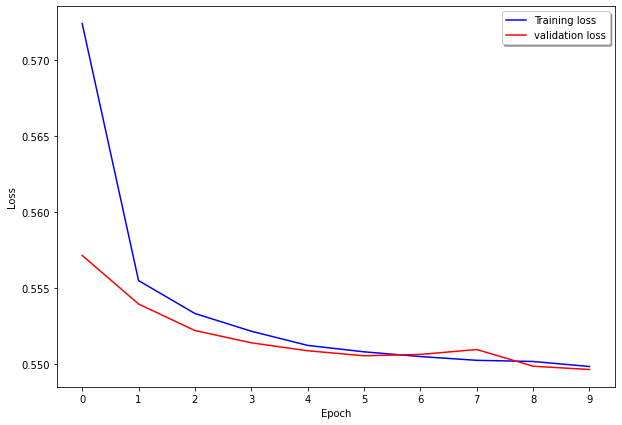

In [55]:
loss_acc_plt(half_sized_model)

**17. Plot 10 examples of reconstructed images (once the network has been fully trained) together with their original counterparts.**

Original input


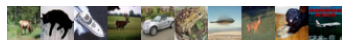

Reconstructed output


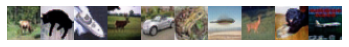

In [59]:
from torch.autograd import Variable

dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Original input")
imshow(torchvision.utils.make_grid(images[:10], nrow=10, padding = 0))

images = Variable(images.cuda())
decoded_imgs = model(images)[1]

print("Reconstructed output")
imshow(torchvision.utils.make_grid(decoded_imgs.data[:10], nrow=10, padding = 0))

**18. Train second model**

In [40]:
num_epochs = 10
learning_rate = 0.005

model=QuarterSizedBottleneckAE()

quarter_sized_model = init_model(num_epochs, learning_rate, model)


Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             336
         LeakyReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 36, 16, 16]           6,948
         LeakyReLU-4           [-1, 36, 16, 16]               0
            Conv2d-5            [-1, 108, 8, 8]          62,316
         LeakyReLU-6            [-1, 108, 8, 8]               0
   ConvTranspose2d-7           [-1, 36, 16, 16]          62,244
         LeakyReLU-8           [-1, 36, 16, 16]               0
   ConvTranspose2d-9           [-1, 12, 32, 32]           6,924
        LeakyReLU-10           [-1, 12, 32, 32]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             327
        LeakyReLU-12            [-1, 3, 32, 32]               0
Total params: 139,095
Trainable params: 139,095
Non-trainable params: 0
----------------

**19. Report the training and validation curves of the reconstruction loss for the first model**

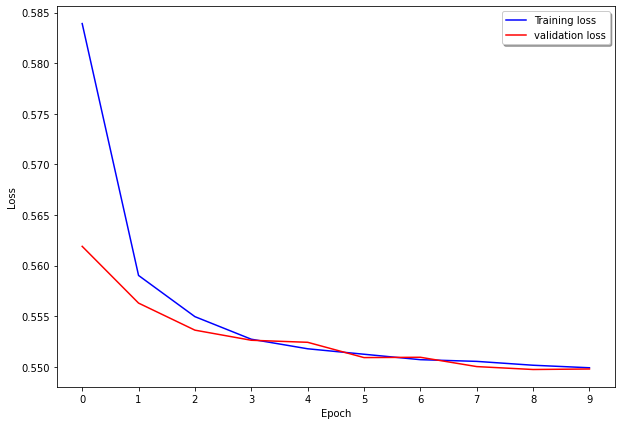

In [56]:
loss_acc_plt(quarter_sized_model)

**20. Plot 10 examples of reconstructed images (once the network has been fully trained) together with their original counterparts.**

Original input


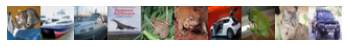

Reconstructed output


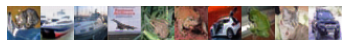

In [60]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

print("Original input")
imshow(torchvision.utils.make_grid(images[:10], nrow=10, padding = 0))

images = Variable(images.cuda())
decoded_imgs = model(images)[1]

print("Reconstructed output")
imshow(torchvision.utils.make_grid(decoded_imgs.data[:10], nrow=10, padding = 0))